In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
from typing import Callable, List
import numpy as np
from jax import random
import matplotlib.pyplot as plt
import equinox as eqx
import optax
import scipy
from tqdm.autonotebook import tqdm

/var/folders/dj/9l55bm1s047crb4scq4r44vh0000gn/T/ipykernel_63650/135736572.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# define 2d FNO, I also wrote a file containing those class definitions, which can be used in further applications

In [3]:
class SpectralConv2d(eqx.Module):
    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes_x: int
    modes_y: int

    def __init__(
            self,
            in_channels,
            out_channels,
            modes_x,
            modes_y,
            *,
            key,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_x = modes_x
        self.modes_y = modes_y


        scale = 1.0 / (in_channels * out_channels)                      # check if this might need change

        real_key, imag_key = jax.random.split(key)
        self.real_weights = jax.random.uniform(
            real_key,
            (in_channels, out_channels, modes_x, modes_y),
            minval=-scale,
            maxval=+scale,
        )
        self.imag_weights = jax.random.uniform(
            imag_key,
            (in_channels, out_channels, modes_x, modes_y),
            minval=-scale,
            maxval=+scale,
        )    
    def complex_mult2d(
            self,
            x_hat,
            w,
    ):
        return jnp.einsum("iXY,ioXY->oXY", x_hat, w)  
    
    def __call__(
            self,
            x,
    ):
        channels, spatial_points_x, spatial_points_y = x.shape

        x_hat = jnp.fft.rfft2(x)                                            # ergänzen das axis 1 und 2?
        x_hat_under_modes = x_hat[:, :self.modes_x, :self.modes_y]
        weights = self.real_weights + 1j * self.imag_weights
        out_hat_under_modes = self.complex_mult2d(x_hat_under_modes, weights)

        out_hat = jnp.zeros(
            (self.out_channels, *x_hat.shape[1:]),
            dtype=x_hat.dtype
        )
        
        out_hat = out_hat.at[:, :self.modes_x, :self.modes_y].set(out_hat_under_modes)

        out = jnp.fft.irfft2(out_hat, s=[spatial_points_x, spatial_points_y])     #previously: n=spatial_points)

        return out


In [4]:
class FNOBlock2d(eqx.Module):
    spectral_conv: SpectralConv2d
    bypass_conv: eqx.nn.Conv2d
    activation: Callable

    def __init__(
            self,
            in_channels,
            out_channels,
            modes_x,
            modes_y,
            activation,
            *,
            key,
    ):
        spectral_conv_key, bypass_conv_key = jax.random.split(key)
        self.spectral_conv = SpectralConv2d(
            in_channels,
            out_channels,
            modes_x,   
            modes_y,
            key=spectral_conv_key,
        )

        self.bypass_conv = eqx.nn.Conv2d(
            in_channels,
            out_channels,
            1,  # Kernel size is one
            key=bypass_conv_key,
        )
        self.activation = activation

    def __call__(
            self,
            x,
    ):
        return self.activation(
            self.spectral_conv(x) + self.bypass_conv(x)
        )
    

In [5]:
class FNO2d(eqx.Module):
    lifting: eqx.nn.Conv2d
    fno_blocks: List[FNOBlock2d]
    projection: eqx.nn.Conv2d

    def __init__(
            self,
            in_channels,
            out_channels,
            modes_x,
            modes_y,
            width,
            activation,
            n_blocks = 4,
            *,
            key,
    ):
        key, lifting_key = jax.random.split(key)
        #lifting erhöht channel dim aber nicht spatial dim
        self.lifting = eqx.nn.Conv2d(
            in_channels,
            width,
            1,
            key=lifting_key,
        )

        self.fno_blocks = []
        for i in range(n_blocks):
            key, subkey = jax.random.split(key)  #bedeutet das, jeder Block wird gleich initialisiert, weil immer gleicher key?
            self.fno_blocks.append(FNOBlock2d(
                width,
                width,
                modes_x,
                modes_y,
                activation,
                key=subkey,
            ))
        #projection umgekehrt zu lifting
        key, projection_key = jax.random.split(key)
        self.projection = eqx.nn.Conv2d(
            width,
            out_channels,
            1,
            key=projection_key,
        )
    def __call__(
            self,
            x,
    ):
        x = self.lifting(x)

        for fno_block in self.fno_blocks:
            x = fno_block(x)

        x = self.projection(x)

        return x

In [42]:
fno2d = FNO2d(
    3,
    1,
    16,
    16,
    64,
    jax.nn.relu,
    key=jax.random.PRNGKey(0),
)

In [7]:
# creating the training data:

In [8]:
def generate_correlated_lognormal_field(
    key,
    shape=(100, 100),
    mean=1.0,
    length_scale=0.1,
    sigma_g=1.0,
    percentile=99
):
    """
    Generate a 2D log-normal random field with spatial correlations.

    Args:
        key: JAX PRNG key.
        shape: tuple (Nx, Ny) of field dimensions.
        mean: desired mean of the real-space log-normal field.
        length_scale: controls correlation (smaller = more small-scale structure).
        sigma_g: std dev of the Gaussian log field (controls contrast).
        percentile: used to return a mask of "top X%" regions.

    Returns:
        field: 2D log-normal field with spatial correlation and given mean.
        top_mask: binary mask of top percentile pixels (e.g., top 1%)
    """
    Nx, Ny = shape
    key, subkey = random.split(key)

    # --- Step 1: define k-space grid
    kx = jnp.fft.fftfreq(Nx) / length_scale
    ky = jnp.fft.fftfreq(Ny) / length_scale
    kx_grid, ky_grid = jnp.meshgrid(kx, ky, indexing='ij')
    k = jnp.sqrt(kx_grid**2 + ky_grid**2)

    # --- Step 2: Power spectrum (Gaussian in log-k)
    k0 = 1.0
    log_k = jnp.log(jnp.clip(k, a_min=1e-6))  # avoid log(0)
    log_k0 = jnp.log(k0)
    sigma_k = 0.5
    P_k = jnp.exp(-0.5 * ((log_k - log_k0) / sigma_k)**2)
    P_k = P_k.at[0, 0].set(0.0)  # zero DC

    # --- Step 3: Generate Gaussian field in Fourier space
    phases = jnp.exp(2j * jnp.pi * random.uniform(subkey, (Nx, Ny)))
    amplitude = jnp.sqrt(P_k)
    fft_field = amplitude * phases

    # Hermitian symmetry for real field
    if Nx % 2 == 0:
        fft_field = fft_field.at[Nx // 2, :].set(fft_field[Nx // 2, :].real)
    if Ny % 2 == 0:
        fft_field = fft_field.at[:, Ny // 2].set(fft_field[:, Ny // 2].real)
    ix = jnp.arange(0, Nx // 2)
    iy = jnp.arange(0, Ny // 2)
    fft_field = fft_field.at[-ix[:, None], -iy[None, :]].set(jnp.conj(fft_field[ix[:, None], iy[None, :]]))

    # --- Step 4: Inverse FFT → correlated Gaussian field
    g = jnp.fft.ifft2(fft_field).real
    g = (g - jnp.mean(g)) / jnp.std(g)  # normalize to mean=0, std=1
    g = sigma_g * g

    # --- Step 5: Exponentiate to log-normal
    lognormal_field = jnp.exp(g)

    # --- Step 6: Rescale to desired mean
    current_mean = jnp.mean(lognormal_field)
    field = lognormal_field * (mean / current_mean)

    # --- Step 7: Create top-X% mask
    threshold = jnp.percentile(field, percentile)
    top_mask = field >= threshold

    return field, top_mask



In [9]:
def compute_intensity(
        shape=(100, 100),
        field=1,
        sigma_value = 0.05
        
):
    # Grid and parameters
    #Nx, Ny = 100, 100
    Nx, Ny = shape
    Lx, Ly = 1.0, 1.0
    dx, dy = Lx / Nx, Ly / Ny
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Opacity and emissivity
    kappa = field # 1.0 ## here your density field
    j0 = 10.0
    xc, yc = Lx / 2, Ly / 2
    sigma = sigma_value # 0.05
    j_emissivity = j0 * np.exp(-((X - xc)**2 + (Y - yc)**2) / (2 * sigma**2))

    # Angular discretization
    N_theta = 16
    theta_list = np.linspace(0, 2 * np.pi, N_theta, endpoint=False)

    # Storage for total intensity
    J = np.zeros((Nx, Ny))


    # Solve RTE for each angle
    for theta in theta_list:
        mu_x = np.cos(theta)
        mu_y = np.sin(theta)
        I = np.zeros((Nx, Ny))
        
        # Determine sweep order based on angle
        i_range = range(Nx) if mu_x >= 0 else range(Nx - 1, -1, -1)
        j_range = range(Ny) if mu_y >= 0 else range(Ny - 1, -1, -1)
        
        for i in i_range:
            for j in j_range:
                if (i - np.sign(mu_x) < 0 or i - np.sign(mu_x) >= Nx or
                    j - np.sign(mu_y) < 0 or j - np.sign(mu_y) >= Ny):
                    I_up_x = 0.0
                    I_up_y = 0.0
                else:
                    I_up_x = I[int(i - np.sign(mu_x)), j]
                    I_up_y = I[i, int(j - np.sign(mu_y))]
                denom = abs(mu_x) / dx + abs(mu_y) / dy + kappa[i, j]
                I_avg = (abs(mu_x) * I_up_x / dx + abs(mu_y) * I_up_y / dy) / denom
                source = j_emissivity[i, j] / denom
                I[i, j] = I_avg + source
                #I = I.at[i,j].set(I_avg + source) -> use when using jnp instead of np
        
        J += I  # Accumulate for mean intensity

    # Compute mean intensity
    J /= N_theta
    return J.T 

# I can make this more efficient by vmapping of theta in theta list and by using fori_loop instead of normal loops 
# with this I can than also vmap the whole function (jit too)

In [10]:
def create_data(
        key,
        shape=(100, 100),
        mean=1.0,
        length_scale=0.1,
        sigma_g=1.0,
        percentile=99,
        sigma=0.05
):
    
    field, mask = generate_correlated_lognormal_field(key, shape, mean, length_scale, sigma_g, percentile)  # maybe don't use as parameters but instead initialize specific parameters in function randomly 
    intensity = compute_intensity(shape, field, sigma)

    return field, mask, intensity
# should also return the r-grid since this will also be used as input for the network  



# check, if it is necessary to speed up the RTE (and than vmap also create_data) - if so there are some comments above how to speed it up

In [14]:
key = random.PRNGKey(0)
keys = random.split(key, 150)
key2 = random.PRNGKey(1) 
keys2 = random.split(key2, 3)

length_scales = random.uniform(keys2[0], shape=(150,), minval=0.1, maxval=10.0)
sigma_gs = random.uniform(keys2[1], shape=(150,), minval=0.1, maxval=2.0)
sigmas = jnp.ones(shape=(150,)) * 0.05
#sigmas = random.uniform(keys2[2], shape=(3,), minval=0.03, maxval=0.07)

results = []
i = 0
for k, l, sg, s in zip(keys, length_scales, sigma_gs, sigmas):
    result = create_data(k, (100,100), 1.0, l, sg, 99, s)
    #result = create_data(key, (100,100), 1.0, 0.1, 1.5, 99, 0.05) # testing
    results.append(result)
    if i%10 == 0:
        print(f"{i}/{len(length_scales)}")
    i += 1

0/150
10/150
20/150
30/150
40/150
50/150
60/150
70/150
80/150
90/150
100/150
110/150
120/150
130/150
140/150


In [29]:
data_x =  jnp.array([result[0] for result in results])
data_x = data_x[:, jnp.newaxis, :, :]
x = jnp.linspace(0, 1, 100)   # adapt s.t. it is created based on length of results 
X, Y = jnp.meshgrid(x, x)
X_shape_corrected = jnp.repeat(X[jnp.newaxis, jnp.newaxis, :], data_x.shape[0], axis=0)
Y_shape_corrected = jnp.repeat(Y[jnp.newaxis, jnp.newaxis, :], data_x.shape[0], axis=0)
data_x_with_mesh = jnp.concatenate((data_x, X_shape_corrected, Y_shape_corrected), axis=1)

data_y =  jnp.array([result[2] for result in results])
data_y = data_y[:, jnp.newaxis, :, :]


train_x, test_x = data_x_with_mesh[:100], data_x_with_mesh[100:150]  
train_y, test_y = data_y[:100], data_y[100:150]



(100, 1, 100, 100)

In [43]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

In [44]:
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(fno2d, eqx.is_array))

@eqx.filter_jit   #was bedeutet das?
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, test_x, test_y)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss

loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)
for epoch in tqdm(range(100)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x,   # maybe check if reduced resolution also works
        train_y,
        batch_size=10,
    ):
        fno2d, opt_state, loss, val_loss = make_step(fno2d, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

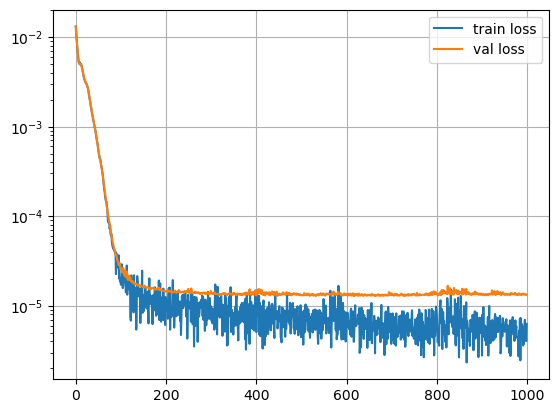

In [45]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

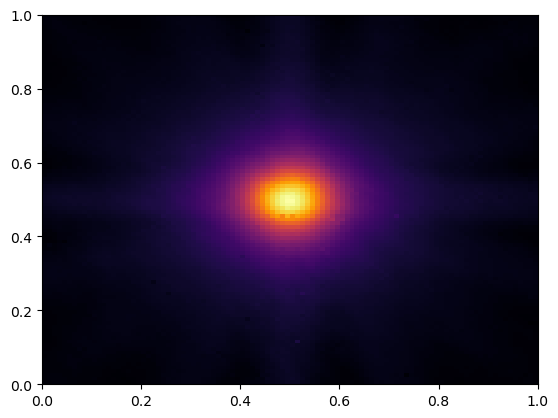

In [53]:
plt.imshow(fno2d(test_x[1, :, :, :])[0], origin='lower', extent=[0, 1, 0, 1,], aspect='auto', cmap='inferno')
plt.show()

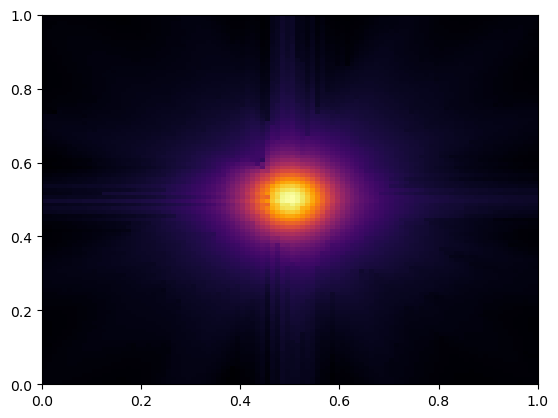

In [54]:
plt.imshow(test_y[1, 0, :, :], origin='lower', extent=[0, 1, 0, 1,], aspect='auto', cmap='inferno')
plt.show()